In [153]:
import pandas as pd
import numpy as np 
import numpy.random as npr
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import io
import re
from scipy.interpolate import interp1d
from datetime import datetime
from datetime import timezone
from math import sqrt
from scipy.stats import norm

In [154]:
capnormal_data=pd.read_csv("HA_capNormalVol.csv")
swaps_data=pd.read_csv("HA_swaps.csv")
swaption_data=pd.read_csv("HA_swaptionNormalVol.csv")
swaps_data

,Unnamed: 0,Deposit 6M,FRA 1X7,FRA 2X8,FRA 3X9,FRA 4X10,FRA 5X11,FRA 6X12,FRA 7X13,FRA 8X14,...,Swap 9Y,Swap 10Y,Swap 11Y,Swap 12Y,Swap 15Y,Swap 20Y,Swap 25Y,Swap 30Y,Swap 40Y,Swap 50Y
0,2007-01-02,3.85700,3.92850,3.97700,4.01550,4.04550,4.07550,4.09750,4.09650,4.10100,...,4.15200,4.17200,4.18700,4.20600,4.24450,4.28400,4.27500,4.25900,4.21600,4.17400
1,2007-01-03,3.86000,3.91700,3.97200,4.01450,4.04100,4.06700,4.08200,4.08700,4.09200,...,4.15050,4.17150,4.18850,4.20450,4.25800,4.28450,4.29500,4.26350,4.22050,4.17850
2,2007-01-04,3.86500,3.93150,3.98650,4.02250,4.04350,4.07200,4.09150,4.09750,4.10250,...,4.14450,4.16250,4.18150,4.19850,4.24550,4.27550,4.27800,4.25650,4.21450,4.17250
3,2007-01-05,3.86400,3.94150,3.99500,4.04100,4.07100,4.09500,4.12200,4.13050,4.13650,...,4.18750,4.20550,4.22350,4.24050,4.28850,4.31750,4.32900,4.29700,4.25500,4.21500
4,2007-01-08,3.87400,3.94350,4.00150,4.04350,4.06950,4.09850,4.12250,4.12150,4.12750,...,4.18600,4.20600,4.22600,4.24200,4.28850,4.32000,4.32100,4.30000,4.25900,4.22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,2020-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.16200,0.21070,NaN,0.13460,0.06100,NaN
3641,2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.19350,NaN,NaN,NaN,-0.00850,0.03410,-0.00120,-0.06100,-0.15900,NaN
3642,2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57600,0.53000,NaN
3643,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62110,0.57510,NaN


In [155]:
swaps_data=pd.read_csv("HA_swaps.csv")
swaps_data['Unnamed: 0']=pd.to_datetime(swaps_data['Unnamed: 0'])
swaps_data.sort_values('Unnamed: 0',inplace=True)
swaps_data.set_index('Unnamed: 0',inplace=True)

In [156]:
swaps_data.interpolate(method='time', limit_direction='both', axis=0,inplace=True)

In [157]:
swaps_data.reset_index(inplace=True)
swaps_data['Unnamed: 0']=swaps_data['Unnamed: 0'].dt.strftime('%Y-%m-%d')
swaps_data

,Unnamed: 0,Deposit 6M,FRA 1X7,FRA 2X8,FRA 3X9,FRA 4X10,FRA 5X11,FRA 6X12,FRA 7X13,FRA 8X14,...,Swap 9Y,Swap 10Y,Swap 11Y,Swap 12Y,Swap 15Y,Swap 20Y,Swap 25Y,Swap 30Y,Swap 40Y,Swap 50Y
0,2007-01-01,3.85700,3.91600,3.97400,4.02000,4.05100,4.09300,4.10000,4.09650,4.10100,...,4.18000,4.20000,4.21700,4.23300,4.27500,4.31200,4.31100,4.28900,4.24600,4.20400
1,2007-01-02,3.85700,3.92850,3.97700,4.01550,4.04550,4.07550,4.09750,4.09650,4.10100,...,4.15200,4.17200,4.18700,4.20600,4.24450,4.28400,4.27500,4.25900,4.21600,4.17400
2,2007-01-03,3.86000,3.91700,3.97200,4.01450,4.04100,4.06700,4.08200,4.08700,4.09200,...,4.15050,4.17150,4.18850,4.20450,4.25800,4.28450,4.29500,4.26350,4.22050,4.17850
3,2007-01-04,3.86500,3.93150,3.98650,4.02250,4.04350,4.07200,4.09150,4.09750,4.10250,...,4.14450,4.16250,4.18150,4.19850,4.24550,4.27550,4.27800,4.25650,4.21450,4.17250
4,2007-01-05,3.86400,3.94150,3.99500,4.04100,4.07100,4.09500,4.12200,4.13050,4.13650,...,4.18750,4.20550,4.22350,4.24050,4.28850,4.31750,4.32900,4.29700,4.25500,4.21500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,2020-12-14,-0.52200,-0.53400,-0.52850,-0.53200,-0.53850,-0.54100,-0.54100,-0.54300,-0.54600,...,-0.34050,-0.29650,-0.25500,-0.21300,-0.11800,-0.04250,-0.03950,-0.06750,-0.12450,-0.16900
3641,2020-12-15,-0.52000,-0.52250,-0.53200,-0.53150,-0.53600,-0.53750,-0.53800,-0.54000,-0.54300,...,-0.33700,-0.29200,-0.25000,-0.21100,-0.11300,-0.03400,-0.03200,-0.06000,-0.11500,-0.16450
3642,2020-12-16,-0.52500,-0.51850,-0.51800,-0.51800,-0.51900,-0.52200,-0.52100,-0.52400,-0.52400,...,-0.30700,-0.26400,-0.22200,-0.18100,-0.08450,-0.00730,-0.00500,-0.03250,-0.08800,-0.13600
3643,2020-12-17,-0.51800,-0.51600,-0.51700,-0.51600,-0.51800,-0.51900,-0.51700,-0.51900,-0.52400,...,-0.31100,-0.26600,-0.22350,-0.18200,-0.08200,0.00000,0.00330,-0.02300,-0.08000,-0.12700


In [158]:
def schedule(start, end, freq=6):            
    def advance(dt, months):
        try:
            return date(dt.year, dt.month + months, dt.day)
        except:
            return date(dt.year + 1, dt.month - months, dt.day)
    dates = [start]
    while dates[-1] <= end:
        dates.append(advance(dates[-1], 6))
    return dates[:-1]

In [159]:
#Exercise 1
#creating schedule of dates
today_date = date(2007,1,15)
maturity = date(2022,1,19)
start_date = date(2007,1,19)

In [160]:
#Exercise 1
swaps = swaps_data.rename(columns={'Unnamed: 0': 'Date'}) #changing name of columns
swaps['Date'] = pd.to_datetime(swaps['Date']) #setting the Date columns to a datetime columns
swaps.set_index('Date', inplace=True) #setting the column as the index
swaps

,Deposit 6M,FRA 1X7,FRA 2X8,FRA 3X9,FRA 4X10,FRA 5X11,FRA 6X12,FRA 7X13,FRA 8X14,FRA 9X15,...,Swap 9Y,Swap 10Y,Swap 11Y,Swap 12Y,Swap 15Y,Swap 20Y,Swap 25Y,Swap 30Y,Swap 40Y,Swap 50Y
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,3.85700,3.91600,3.97400,4.02000,4.05100,4.09300,4.10000,4.09650,4.10100,4.10050,...,4.18000,4.20000,4.21700,4.23300,4.27500,4.31200,4.31100,4.28900,4.24600,4.20400
2007-01-02,3.85700,3.92850,3.97700,4.01550,4.04550,4.07550,4.09750,4.09650,4.10100,4.10050,...,4.15200,4.17200,4.18700,4.20600,4.24450,4.28400,4.27500,4.25900,4.21600,4.17400
2007-01-03,3.86000,3.91700,3.97200,4.01450,4.04100,4.06700,4.08200,4.08700,4.09200,4.08900,...,4.15050,4.17150,4.18850,4.20450,4.25800,4.28450,4.29500,4.26350,4.22050,4.17850
2007-01-04,3.86500,3.93150,3.98650,4.02250,4.04350,4.07200,4.09150,4.09750,4.10250,4.09850,...,4.14450,4.16250,4.18150,4.19850,4.24550,4.27550,4.27800,4.25650,4.21450,4.17250
2007-01-05,3.86400,3.94150,3.99500,4.04100,4.07100,4.09500,4.12200,4.13050,4.13650,4.13250,...,4.18750,4.20550,4.22350,4.24050,4.28850,4.31750,4.32900,4.29700,4.25500,4.21500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,-0.52200,-0.53400,-0.52850,-0.53200,-0.53850,-0.54100,-0.54100,-0.54300,-0.54600,-0.55600,...,-0.34050,-0.29650,-0.25500,-0.21300,-0.11800,-0.04250,-0.03950,-0.06750,-0.12450,-0.16900
2020-12-15,-0.52000,-0.52250,-0.53200,-0.53150,-0.53600,-0.53750,-0.53800,-0.54000,-0.54300,-0.55000,...,-0.33700,-0.29200,-0.25000,-0.21100,-0.11300,-0.03400,-0.03200,-0.06000,-0.11500,-0.16450
2020-12-16,-0.52500,-0.51850,-0.51800,-0.51800,-0.51900,-0.52200,-0.52100,-0.52400,-0.52400,-0.53000,...,-0.30700,-0.26400,-0.22200,-0.18100,-0.08450,-0.00730,-0.00500,-0.03250,-0.08800,-0.13600


In [161]:
swaps_v1=swaps.loc['2007-01-15 00:00:00'].to_frame()
swaps_v1.columns=['par_rate']
swaps_v1.reset_index(inplace=True)
swaps_v1

,index,par_rate
0,Deposit 6M,3.88000
1,FRA 1X7,3.95200
2,FRA 2X8,4.02600
3,FRA 3X9,4.06590
4,FRA 4X10,4.10480
5,FRA 5X11,4.13860
6,FRA 6X12,4.15430
7,FRA 7X13,4.16060
8,FRA 8X14,4.16890
9,FRA 9X15,4.16750


In [162]:
swaps_v1[['instrument', 'maturity']] = swaps_v1['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product

In [163]:
swaps_v1["maturity"] = swaps_v1["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities

In [164]:
swaps_v1['maturity_fra'] = swaps_v1['maturity'].str.split('X').str[1] #getting the maturity of the fra

In [165]:
swaps_v1.loc[swaps_v1["instrument"] == "FRA", "maturity"] = swaps_v1["maturity_fra"] #getting the new maturity

In [166]:
def extract_number(string):
    # Use a regular expression to extract the numeric value from the string
    number = re.findall(r'\d+', string)
    # If the string contains the character 'M', return the number as a float
    # (dividing the number by 12 to convert from months to years)
    if 'M' in string:
        return float(number[0]) / 12
    # Otherwise, return the number as an integer
    else:
        return int(number[0])

In [167]:
swaps_v1["year_frac"] = swaps_v1["maturity"].apply(extract_number)

In [168]:
swaps_v1.set_index('index',inplace=True)

In [169]:
forward=swaps_v1.loc['FRA 6X12', 'par_rate']

In [170]:
one_year_rate=(((1+swaps_v1.loc['Deposit 6M', 'par_rate'])**swaps_v1.loc['Deposit 6M', 'year_frac'])*(1+forward)**(1-swaps_v1.loc['Deposit 6M', 'year_frac']))-1
one_year_rate

4.015275067232105

In [171]:
yield_curve = swaps_v1[swaps_v1.index.str.contains("FRA") == False]
yield_curve

,par_rate,instrument,maturity,maturity_fra,year_frac
index,,,,,
Deposit 6M,3.88000,Deposit,6M,NaN,0.50000
Swap 2Y,4.16900,Swap,2Y,NaN,2.00000
Swap 3Y,4.17250,Swap,3Y,NaN,3.00000
Swap 4Y,4.17550,Swap,4Y,NaN,4.00000
Swap 5Y,4.18450,Swap,5Y,NaN,5.00000
Swap 6Y,4.20250,Swap,6Y,NaN,6.00000
Swap 7Y,4.21850,Swap,7Y,NaN,7.00000
Swap 8Y,4.24250,Swap,8Y,NaN,8.00000
Swap 9Y,4.26450,Swap,9Y,NaN,9.00000


In [172]:
one_year_rate_frame = pd.DataFrame([[one_year_rate,'-','1Y','-',1.0]],
     index=['Swap 1Y'],
     columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])
one_year_rate_frame

,par_rate,instrument,maturity,maturity_fra,year_frac
Swap 1Y,4.01528,-,1Y,-,1.00000


In [173]:
yield_curve=yield_curve.append(one_year_rate_frame)

In [174]:
yield_curve.set_index('year_frac',inplace=True)

In [175]:
yield_curve.loc[0.5, 'df'] = 1 / (1 + (yield_curve.loc[0.5, 'par_rate']/100) * 0.5)
yield_curve.loc[0.5, 'zero_rate'] = yield_curve.loc[0.5, 'par_rate']/100

In [176]:
yield_curve.loc[1, 'df'] = 1 / (1 + yield_curve.loc[1, 'par_rate']/100 * 1)
yield_curve.loc[1, 'zero_rate'] = yield_curve.loc[1, 'par_rate']/100

In [177]:
yield_curve=yield_curve.sort_index()

In [178]:
yield_curve

,par_rate,instrument,maturity,maturity_fra,df,zero_rate
year_frac,,,,,,
0.50000,3.88000,Deposit,6M,NaN,0.98097,0.03880
1.00000,4.01528,-,1Y,-,0.96140,0.04015
2.00000,4.16900,Swap,2Y,NaN,NaN,NaN
3.00000,4.17250,Swap,3Y,NaN,NaN,NaN
4.00000,4.17550,Swap,4Y,NaN,NaN,NaN
5.00000,4.18450,Swap,5Y,NaN,NaN,NaN
6.00000,4.20250,Swap,6Y,NaN,NaN,NaN
7.00000,4.21850,Swap,7Y,NaN,NaN,NaN
8.00000,4.24250,Swap,8Y,NaN,NaN,NaN


In [179]:
date(start_date.year,start_date.month,start_date.day)

datetime.date(2007, 1, 19)

In [180]:
yield_curve["Tenor"]= yield_curve.index
yield_curve['maturity'] = [date(start_date.year,start_date.month+6,start_date.day)] + [date(2007 +int(n), 1, 19) for n in yield_curve.index[1:]]
yield_curve['days'] = yield_curve.maturity.apply(lambda x: (x - start_date).days)
yield_curve

,par_rate,instrument,maturity,maturity_fra,df,zero_rate,Tenor,days
year_frac,,,,,,,,
0.50000,3.88000,Deposit,2007-07-19,NaN,0.98097,0.03880,0.50000,181
1.00000,4.01528,-,2008-01-19,-,0.96140,0.04015,1.00000,365
2.00000,4.16900,Swap,2009-01-19,NaN,NaN,NaN,2.00000,731
3.00000,4.17250,Swap,2010-01-19,NaN,NaN,NaN,3.00000,1096
4.00000,4.17550,Swap,2011-01-19,NaN,NaN,NaN,4.00000,1461
5.00000,4.18450,Swap,2012-01-19,NaN,NaN,NaN,5.00000,1826
6.00000,4.20250,Swap,2013-01-19,NaN,NaN,NaN,6.00000,2192
7.00000,4.21850,Swap,2014-01-19,NaN,NaN,NaN,7.00000,2557
8.00000,4.24250,Swap,2015-01-19,NaN,NaN,NaN,8.00000,2922


In [181]:
for idx, row in yield_curve.loc[2:].iterrows():
    prev_dfs = yield_curve.loc[1:idx-1].df.sum()
    yield_curve.loc[idx, 'df'] = (1 - row.par_rate/100 * prev_dfs) / (1+row.par_rate/100)

In [182]:
yield_curve

,par_rate,instrument,maturity,maturity_fra,df,zero_rate,Tenor,days
year_frac,,,,,,,,
0.50000,3.88000,Deposit,2007-07-19,NaN,0.98097,0.03880,0.50000,181
1.00000,4.01528,-,2008-01-19,-,0.96140,0.04015,1.00000,365
2.00000,4.16900,Swap,2009-01-19,NaN,0.92150,NaN,2.00000,731
3.00000,4.17250,Swap,2010-01-19,NaN,0.88453,NaN,3.00000,1096
4.00000,4.17550,Swap,2011-01-19,NaN,0.84900,NaN,4.00000,1461
5.00000,4.18450,Swap,2012-01-19,NaN,0.81458,NaN,5.00000,1826
6.00000,4.20250,Swap,2013-01-19,NaN,0.78097,NaN,6.00000,2192
7.00000,4.21850,Swap,2014-01-19,NaN,0.74856,NaN,7.00000,2557
8.00000,4.24250,Swap,2015-01-19,NaN,0.71672,NaN,8.00000,2922


In [183]:

for a in yield_curve.index[2:]:
    yield_curve.loc[a,'zero_rate']=((1/yield_curve.loc[a,'df'])**(1/a))-1


In [184]:
yield_curve.loc[15,'df']=yield_curve.loc[11,'df']+(15-10)*((0.5998486551576877-0.6274500092316508)/(12-11))
yield_curve.loc[15,'df']

0.48944323886183516

In [185]:
start_date = date(2007,1,19)
# Add six months and keep the same day
loan_dates=[start_date]
for i in range(30):
  resulting_date = start_date + relativedelta(months=+6)
  if resulting_date.weekday()==5:
    resulting_date=resulting_date+timedelta(days=2)
  if resulting_date.weekday()==6:
    resulting_date=resulting_date+timedelta(days=1)
  loan_dates.append(resulting_date)
  start_date=date(resulting_date.year,resulting_date.month,19)
start_date = date(2007,1,19)
loan_dates

[datetime.date(2007, 1, 19),
 datetime.date(2007, 7, 19),
 datetime.date(2008, 1, 21),
 datetime.date(2008, 7, 21),
 datetime.date(2009, 1, 19),
 datetime.date(2009, 7, 20),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 7, 19),
 datetime.date(2011, 1, 19),
 datetime.date(2011, 7, 19),
 datetime.date(2012, 1, 19),
 datetime.date(2012, 7, 19),
 datetime.date(2013, 1, 21),
 datetime.date(2013, 7, 19),
 datetime.date(2014, 1, 20),
 datetime.date(2014, 7, 21),
 datetime.date(2015, 1, 19),
 datetime.date(2015, 7, 20),
 datetime.date(2016, 1, 19),
 datetime.date(2016, 7, 19),
 datetime.date(2017, 1, 19),
 datetime.date(2017, 7, 19),
 datetime.date(2018, 1, 19),
 datetime.date(2018, 7, 19),
 datetime.date(2019, 1, 21),
 datetime.date(2019, 7, 19),
 datetime.date(2020, 1, 20),
 datetime.date(2020, 7, 20),
 datetime.date(2021, 1, 19),
 datetime.date(2021, 7, 19),
 datetime.date(2022, 1, 19)]

In [186]:
nr_days=[]
for a in range(0,len(loan_dates)):
    if a ==0:
      pass
    else:
      nr_days.append((loan_dates[a]-today_date).days/365)
nr_days

[0.5068493150684932,
 1.0164383561643835,
 1.515068493150685,
 2.0136986301369864,
 2.5123287671232877,
 3.0136986301369864,
 3.5095890410958903,
 4.013698630136986,
 4.50958904109589,
 5.013698630136986,
 5.512328767123288,
 6.021917808219178,
 6.512328767123288,
 7.019178082191781,
 7.517808219178082,
 8.016438356164384,
 8.515068493150684,
 9.016438356164384,
 9.515068493150684,
 10.01917808219178,
 10.515068493150684,
 11.01917808219178,
 11.515068493150684,
 12.024657534246575,
 12.515068493150684,
 13.021917808219179,
 13.520547945205479,
 14.021917808219179,
 14.517808219178082,
 15.021917808219179]

In [187]:
y=np.array(yield_curve.zero_rate.values)
x=np.array(yield_curve.index.values)
y_interp = interp1d(x,y)
 
# Finding the interpolation
interpolated_rates=[]
for a in nr_days:
  interpolate_x=a
  interpolated_rates.append(float(y_interp(interpolate_x)))
interpolated_rates

[0.038818530831127684,
 0.0401785480772134,
 0.04096106935894772,
 0.04172244627297853,
 0.04173531257030465,
 0.04174825530203538,
 0.04176125871019032,
 0.04177540709209084,
 0.041822056504942834,
 0.04187087887849022,
 0.041968737505568496,
 0.0420683090732121,
 0.04215475890475419,
 0.04224594754610628,
 0.04238171355993787,
 0.04251715209004331,
 0.04264298443084846,
 0.04276977762419703,
 0.04290378376868447,
 0.04303887093294358,
 0.04316201576346114,
 0.043286799221674215,
 0.04339953792666865,
 0.043465482029131246,
 0.04258434181141895,
 0.04167366616741463,
 0.04077775823655632,
 0.03987692773464934,
 0.038985942374839704,
 0.03808843304905318]

In [188]:
notional=1748653.15
installemnts=np.full(30,1748653.15)
int_pay=installemnts*interpolated_rates
int_pay[len(int_pay)-1]=notional*(1+interpolated_rates[len(interpolated_rates)-1])
int_pay

array([ 67880.14621622, 70258.34465765, 71626.70296189,
 72958.08710095, 72980.5857923 , 73003.21814091,
 73025.95659154, 73050.69720412, 73132.27084685,
 73217.64424414, 73388.76504064, 73562.88117605,
 73714.05194629, 73873.50925123, 74110.91691898,
 74347.75193128, 74567.7890504 , 74789.50636735,
 75023.83663403, 75260.05722934, 75475.39482513,
 75693.5978124 , 75890.73870401, 76006.05206651,
 74465.24344921, 72872.7876157 , 71306.15539029,
 69730.91529552, 68172.89093948, 1815256.60842979])

In [189]:
#Exercise 2
#The company is Party A
swap_notional=1748653.15
start_swap=loan_dates[0]
maturity_swap=loan_dates[-1]
#Party A Receives Euribor 6m, half yearly, act/360
#Party A Pays xxxxxxxx, half yearly, act/360

In [190]:
#TESTE
yield_curve_swap = yield_curve.copy()
yield_curve_swap

,par_rate,instrument,maturity,maturity_fra,df,zero_rate,Tenor,days
year_frac,,,,,,,,
0.50000,3.88000,Deposit,2007-07-19,NaN,0.98097,0.03880,0.50000,181
1.00000,4.01528,-,2008-01-19,-,0.96140,0.04015,1.00000,365
2.00000,4.16900,Swap,2009-01-19,NaN,0.92150,0.04172,2.00000,731
3.00000,4.17250,Swap,2010-01-19,NaN,0.88453,0.04175,3.00000,1096
4.00000,4.17550,Swap,2011-01-19,NaN,0.84900,0.04177,4.00000,1461
5.00000,4.18450,Swap,2012-01-19,NaN,0.81458,0.04187,5.00000,1826
6.00000,4.20250,Swap,2013-01-19,NaN,0.78097,0.04206,6.00000,2192
7.00000,4.21850,Swap,2014-01-19,NaN,0.74856,0.04224,7.00000,2557
8.00000,4.24250,Swap,2015-01-19,NaN,0.71672,0.04251,8.00000,2922


In [191]:
def getDF(dt):
    x = (dt - start_date).days
    return np.interp(x, yield_curve_swap.days, yield_curve_swap.df)

def getFwd(start, end):
    DF0 = getDF(start)
    DF1 = getDF(end)
    n = (end - start).days / 360
    return (DF0 / DF1 - 1) / n

In [192]:
#get floating leg
pd.options.display.float_format = '{:,.5f}'.format
float_leg = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[:-1],
    'end': loan_dates[1:]
})

float_leg['dcf'] = float_leg.apply(lambda x: (x.end - x.start).days / 360, axis=1)
float_leg['fwd'] = float_leg.apply(lambda row: getFwd(row.start, row.end), axis=1)
float_leg.loc[0, 'fwd'] = yield_curve_swap.loc[0.5, 'par_rate']/100
float_leg['cf'] = float_leg.notional * float_leg.dcf * float_leg.fwd
float_leg['df'] = float_leg.end.apply(getDF)
float_leg['pv'] = float_leg.cf * float_leg.df


float_leg_pv = float_leg.pv.sum()
print(f"PV of float leg is: {float_leg_pv:,.2f}")
float_leg

PV of float leg is: 892,971.57


,notional,start,end,dcf,fwd,cf,df,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,0.50278,0.03880,"34,112.33706",0.98097,"33,463.15191"
1,"1,748,653.15000",2007-07-19,2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,"34,605.75683"
2,"1,748,653.15000",2008-01-21,2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,"34,690.93149"
3,"1,748,653.15000",2008-07-21,2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,"34,690.93149"
4,"1,748,653.15000",2009-01-19,2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,"32,237.80296"
5,"1,748,653.15000",2009-07-20,2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,"32,414.93374"
6,"1,748,653.15000",2010-01-19,2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,"30,811.97511"
7,"1,748,653.15000",2010-07-19,2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,"31,322.67083"
8,"1,748,653.15000",2011-01-19,2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,"29,839.82821"
9,"1,748,653.15000",2011-07-19,2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,"30,334.41100"


In [193]:
fixed_leg = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[::1][:-1],
    'end': loan_dates[::1][1:]
})

fixed_leg['dcf'] = 1
fixed_leg['df'] = fixed_leg.end.apply(getDF)
fixed_leg

,notional,start,end,dcf,df
0,"1,748,653.15000",2007-01-19,2007-07-19,1,0.98097
1,"1,748,653.15000",2007-07-19,2008-01-21,1,0.96118
2,"1,748,653.15000",2008-01-21,2008-07-21,1,0.94134
3,"1,748,653.15000",2008-07-21,2009-01-19,1,0.92150
4,"1,748,653.15000",2009-01-19,2009-07-20,1,0.90307
5,"1,748,653.15000",2009-07-20,2010-01-19,1,0.88453
6,"1,748,653.15000",2010-01-19,2010-07-19,1,0.86691
7,"1,748,653.15000",2010-07-19,2011-01-19,1,0.84900
8,"1,748,653.15000",2011-01-19,2011-07-19,1,0.83193
9,"1,748,653.15000",2011-07-19,2012-01-19,1,0.81458


In [194]:
#getting swap rate with matrix algebra
fixed_rate = float_leg_pv / (fixed_leg.notional *  fixed_leg.dcf * fixed_leg.df).sum()
print(f"Fair fixed rate is: {fixed_rate*100}%")

Fair fixed rate is: 2.3310768356376568%


In [195]:
from scipy.optimize import root
def swapPv(rate):
    fxd = fixed_leg.copy()
    fixed_leg_pv = (fxd.notional * fxd.dcf * fxd.df * rate).sum()
    return fixed_leg_pv - float_leg_pv


res = root(swapPv, 0)
fixed_rate1 = res['x'][0]

print(f"Fixed rate Matrix Algebra:\t {fixed_rate * 100:.4f}%")
print(f"Fixed rate Optimization:\t {fixed_rate1 * 100:.4f}%")

Fixed rate Matrix Algebra:	 2.3311%
Fixed rate Optimization:	 2.3311%


In [196]:
fixed_leg['rate'] = fixed_rate
fixed_leg['cashflow'] = fixed_leg.notional * fixed_leg.dcf * fixed_leg.rate
fixed_leg['pv'] = fixed_leg.cashflow * fixed_leg.df


fixed_leg_pv = fixed_leg.pv.sum()
print(f"Present Value of Fixed Leg is: {fixed_leg_pv:,.2f}")

fixed_leg

Present Value of Fixed Leg is: 892,971.57


,notional,start,end,dcf,df,rate,cashflow,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,1,0.98097,0.02331,"40,762.44852","39,986.70641"
1,"1,748,653.15000",2007-07-19,2008-01-21,1,0.96118,0.02331,"40,762.44852","39,180.01963"
2,"1,748,653.15000",2008-01-21,2008-07-21,1,0.94134,0.02331,"40,762.44852","38,371.34736"
3,"1,748,653.15000",2008-07-21,2009-01-19,1,0.92150,0.02331,"40,762.44852","37,562.67509"
4,"1,748,653.15000",2009-01-19,2009-07-20,1,0.90307,0.02331,"40,762.44852","36,811.18714"
5,"1,748,653.15000",2009-07-20,2010-01-19,1,0.88453,0.02331,"40,762.44852","36,055.57012"
6,"1,748,653.15000",2010-01-19,2010-07-19,1,0.86691,0.02331,"40,762.44852","35,337.31931"
7,"1,748,653.15000",2010-07-19,2011-01-19,1,0.84900,0.02331,"40,762.44852","34,607.16379"
8,"1,748,653.15000",2011-01-19,2011-07-19,1,0.83193,0.02331,"40,762.44852","33,911.57446"
9,"1,748,653.15000",2011-07-19,2012-01-19,1,0.81458,0.02331,"40,762.44852","33,204.45604"


In [197]:
#Question 2b)
pv01 = (fixed_leg.notional * fixed_leg.dcf * 0.0001 * fixed_leg.df).sum()

print(f"Present value of 1 bps on the fixed leg is: EUR {pv01:,.2f}")

Present value of 1 bps on the fixed leg is: EUR 3,830.73


In [198]:
#question 2c
fixed_leg_2c = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[::1][:-1],
    'end': loan_dates[::1][1:]
})

fixed_leg_2c['dcf'] = 1
fixed_leg_2c['df'] = fixed_leg.end.apply(getDF)
fixed_leg_2c

,notional,start,end,dcf,df
0,"1,748,653.15000",2007-01-19,2007-07-19,1,0.98097
1,"1,748,653.15000",2007-07-19,2008-01-21,1,0.96118
2,"1,748,653.15000",2008-01-21,2008-07-21,1,0.94134
3,"1,748,653.15000",2008-07-21,2009-01-19,1,0.92150
4,"1,748,653.15000",2009-01-19,2009-07-20,1,0.90307
5,"1,748,653.15000",2009-07-20,2010-01-19,1,0.88453
6,"1,748,653.15000",2010-01-19,2010-07-19,1,0.86691
7,"1,748,653.15000",2010-07-19,2011-01-19,1,0.84900
8,"1,748,653.15000",2011-01-19,2011-07-19,1,0.83193
9,"1,748,653.15000",2011-07-19,2012-01-19,1,0.81458


In [199]:
#question 2c

fixed_leg_2c['rate'] = fixed_rate+0.0005
fixed_leg_2c['cashflow'] = fixed_leg_2c.notional * fixed_leg_2c.dcf * fixed_leg_2c.rate
fixed_leg_2c['pv'] = fixed_leg_2c.cashflow * fixed_leg_2c.df


fixed_leg_pv_2c = fixed_leg_2c.pv.sum()
print(f"Present Value of Fixed Leg, with the fee, is: {fixed_leg_pv_2c:,.2f}")

Present Value of Fixed Leg, with the fee, is: 912,125.20


In [200]:
#Other way to calculate querstion 2c
pv05 = (fixed_leg.notional * fixed_leg.dcf * 0.0005 * fixed_leg.df).sum()
result_pv05 = fixed_leg_pv + pv05
print(f"The price of this swap considering that the counterparty charges 5bps is: {result_pv05:.3f}")

The price of this swap considering that the counterparty charges 5bps is: 912125.196


In [201]:
#The price of the swap with a 5bps is  3.7953% + 0.0005

In [202]:
#question 2d)
#The market value of this swap 0
market_value = fixed_leg_pv - float_leg_pv
market_value

-2.3283064365386963e-10

In [203]:
#Market value with 5bps fee:
market_value_fee = fixed_leg_pv_2c - float_leg_pv
market_value_fee

19153.627934064134

In [204]:
#Qustion 2e)
beg_date=date(2007,1,31)
last_date=date(2020,11,30)
delta=(last_date-beg_date).days

In [205]:
hist_dates=pd.date_range(beg_date,last_date,freq='d')
hist_dates

DatetimeIndex(['2007-01-31', '2007-02-01', '2007-02-02', '2007-02-03',
               '2007-02-04', '2007-02-05', '2007-02-06', '2007-02-07',
               '2007-02-08', '2007-02-09',
               ...
               '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28',
               '2020-11-29', '2020-11-30'],
              dtype='datetime64[ns]', length=5053, freq='D')

In [206]:
def getDF2(dt):
    x = (dt - start_date).days
    return np.interp(x, yield_curve_hist.days, yield_curve_hist.df)

def getFwd2(start, end):
    DF0 = getDF2(start)
    DF1 = getDF2(end)
    n = (end - start).days / 360
    return (DF0 / DF1 - 1) / n

In [207]:
market_value_hist=[]
picked_dates=[]
for b in hist_dates:
    try:
        swaps_hist=swaps.loc[str(b)].to_frame()
        swaps_hist.columns=['par_rate']
        swaps_hist.reset_index(inplace=True)
        swaps_hist[['instrument', 'maturity']] = swaps_hist['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product
        swaps_hist["maturity"] = swaps_hist["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities
        swaps_hist['maturity_fra'] = swaps_hist['maturity'].str.split('X').str[1] #getting the maturity of the fra
        swaps_hist.loc[swaps_hist["instrument"] == "FRA", "maturity"] = swaps_hist["maturity_fra"] #getting the new maturity
        swaps_hist["year_frac"] = swaps_hist["maturity"].apply(extract_number)
        swaps_hist.set_index('index',inplace=True)
        forward_hist=swaps_hist.loc['FRA 6X12', 'par_rate']
        one_year_rate_hist=(((1+swaps_hist.loc['Deposit 6M', 'par_rate'])**swaps_hist.loc['Deposit 6M', 'year_frac'])*(1+forward_hist)**(1-swaps_hist.loc['Deposit 6M', 'year_frac']))-1
        yield_curve_hist = swaps_hist[swaps_hist.index.str.contains("FRA") == False]
        one_year_rate_frame_hist = pd.DataFrame([[one_year_rate_hist,'-','1Y','-',1.0]],
            index=['Swap 1Y'],
            columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])
        yield_curve_hist=yield_curve_hist.append(one_year_rate_frame_hist)
        yield_curve_hist.set_index('year_frac',inplace=True)
        yield_curve_hist.loc[0.5, 'df'] = 1 / (1 + (yield_curve_hist.loc[0.5, 'par_rate']/100) * 0.5)
        yield_curve_hist.loc[0.5, 'zero_rate'] = yield_curve_hist.loc[0.5, 'par_rate']/100
        yield_curve_hist.loc[1, 'df'] = 1 / (1 + yield_curve_hist.loc[1, 'par_rate']/100 * 1)
        yield_curve_hist.loc[1, 'zero_rate'] = yield_curve_hist.loc[1, 'par_rate']/100
        yield_curve_hist=yield_curve_hist.sort_index()
        yield_curve_hist["Tenor"]= yield_curve_hist.index
        yield_curve_hist['maturity'] = [b+relativedelta(months=+6)] + [date(b.year +int(n), b.month, b.day) for n in yield_curve_hist.index[1:]]
        for n in range(0,len(yield_curve_hist['maturity'])):
            yield_curve_hist.iloc[n,2]=date(yield_curve_hist.iloc[n,2].year,yield_curve_hist.iloc[n,2].month,yield_curve_hist.iloc[n,2].day)
        yield_curve_hist['days'] = yield_curve_hist.maturity.apply(lambda x: (x - date(b.year,b.month,b.day)).days)
        idx_hist=0
        row_hist=0
        for idx_hist, row_hist in yield_curve_hist.loc[2:].iterrows():
            prev_dfs = yield_curve_hist.loc[1:idx_hist-1].df.sum()
            yield_curve_hist.loc[idx_hist, 'df'] = (1 - row_hist.par_rate/100 * prev_dfs) / (1+row_hist.par_rate/100)
        for a in yield_curve_hist.index[2:]:
            yield_curve_hist.loc[a,'zero_rate']=((1/yield_curve_hist.loc[a,'df'])**(1/a))-1
        b = date(b.year,b.month,b.day)
        
        pd.options.display.float_format = '{:,.5f}'.format
        float_leg_hist = pd.DataFrame({'notional': swap_notional,'start': loan_dates[:-1],'end': loan_dates[1:]})
        float_leg_hist['dcf'] = float_leg_hist.apply(lambda x: (x.end - x.start).days / 360, axis=1)
        float_leg_hist['fwd'] = float_leg_hist.apply(lambda row: getFwd2(row.start, row.end), axis=1)
        float_leg_hist.loc[0, 'fwd'] = yield_curve_hist.loc[0.5, 'par_rate']/100
        float_leg_hist['cf'] = float_leg_hist.notional * float_leg_hist.dcf * float_leg_hist.fwd
        float_leg_hist['df'] = float_leg_hist.end.apply(getDF)
        float_leg_hist['pv'] = float_leg_hist.cf * float_leg_hist.df
        for n in range(0,len(float_leg_hist['notional'])):
            if  b>=float_leg_hist.iloc[n,2]:
                float_leg_hist.iloc[n,7]=0
        float_leg_hist_pv = float_leg_hist.pv.sum()
        
        
        fixed_leg_hist = pd.DataFrame({'notional': swap_notional,'start': loan_dates[::1][:-1],'end': loan_dates[::1][1:]})
        fixed_leg_hist['dcf'] = 1
        fixed_leg_hist['df'] = fixed_leg_hist.end.apply(getDF)
        fixed_leg_hist['rate'] = fixed_rate
        fixed_leg_hist['cashflow'] = fixed_leg_hist.notional * fixed_leg_hist.dcf * fixed_leg_hist.rate
        fixed_leg_hist['pv'] = fixed_leg_hist.cashflow * fixed_leg_hist.df
        for n in range(0,len(fixed_leg_hist['notional'])):
            if  b>=fixed_leg_hist.iloc[n,2]:
                fixed_leg_hist.iloc[n,7]=0
        fixed_leg_hist_pv = fixed_leg_hist.pv.sum()
        
        mk_value_hist=fixed_leg_hist_pv-float_leg_hist_pv
        
        
        market_value_hist.append(mk_value_hist)
        picked_dates.append(str(b))
    
    except:
        continue


In [208]:
fixed_leg_hist

,notional,start,end,dcf,df,rate,cashflow,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,1,0.98097,0.02331,"40,762.44852",0.00000
1,"1,748,653.15000",2007-07-19,2008-01-21,1,0.96118,0.02331,"40,762.44852",0.00000
2,"1,748,653.15000",2008-01-21,2008-07-21,1,0.94134,0.02331,"40,762.44852",0.00000
3,"1,748,653.15000",2008-07-21,2009-01-19,1,0.92150,0.02331,"40,762.44852",0.00000
4,"1,748,653.15000",2009-01-19,2009-07-20,1,0.90307,0.02331,"40,762.44852",0.00000
5,"1,748,653.15000",2009-07-20,2010-01-19,1,0.88453,0.02331,"40,762.44852",0.00000
6,"1,748,653.15000",2010-01-19,2010-07-19,1,0.86691,0.02331,"40,762.44852",0.00000
7,"1,748,653.15000",2010-07-19,2011-01-19,1,0.84900,0.02331,"40,762.44852",0.00000
8,"1,748,653.15000",2011-01-19,2011-07-19,1,0.83193,0.02331,"40,762.44852",0.00000
9,"1,748,653.15000",2011-07-19,2012-01-19,1,0.81458,0.02331,"40,762.44852",0.00000


In [209]:
available_dates=swaps.index
available_dates=pd.DataFrame(available_dates)

available_dates = available_dates.loc[(available_dates['Date'] >= '2007-01-31')
                     & (available_dates['Date'] <= '2020-11-30')]
available_dates

,Date
22,2007-01-31
23,2007-02-01
24,2007-02-02
25,2007-02-05
26,2007-02-06
...,...
3626,2020-11-24
3627,2020-11-25
3628,2020-11-26
3629,2020-11-27


In [210]:
#2f

#market value and dates
market_value_df = pd.DataFrame({'Dates': picked_dates,
                   'Value': market_value_hist})
#Fix 15Y Swap data lenght
swp15 = swaps_data[swaps_data["Unnamed: 0"].isin(picked_dates)]
market_value_df['15Y_Swap'] =swp15["Swap 15Y"].tolist()
# convert the date column to a datetime object
market_value_df['Dates'] = pd.to_datetime(market_value_df['Dates'])


market_value_df

,Dates,Value,15Y_Swap
0,2007-01-31,"137,088.20255",4.42780
1,2007-02-01,"138,723.68918",4.41700
2,2007-02-02,"142,705.99179",4.39300
3,2007-02-05,"147,425.46780",4.36600
4,2007-02-06,"150,710.44769",4.34550
...,...,...,...
3601,2020-11-24,"56,576.71213",-0.03800
3602,2020-11-25,"56,643.36010",-0.04500
3603,2020-11-26,"56,726.84001",-0.06200
3604,2020-11-27,"56,917.74425",-0.06800


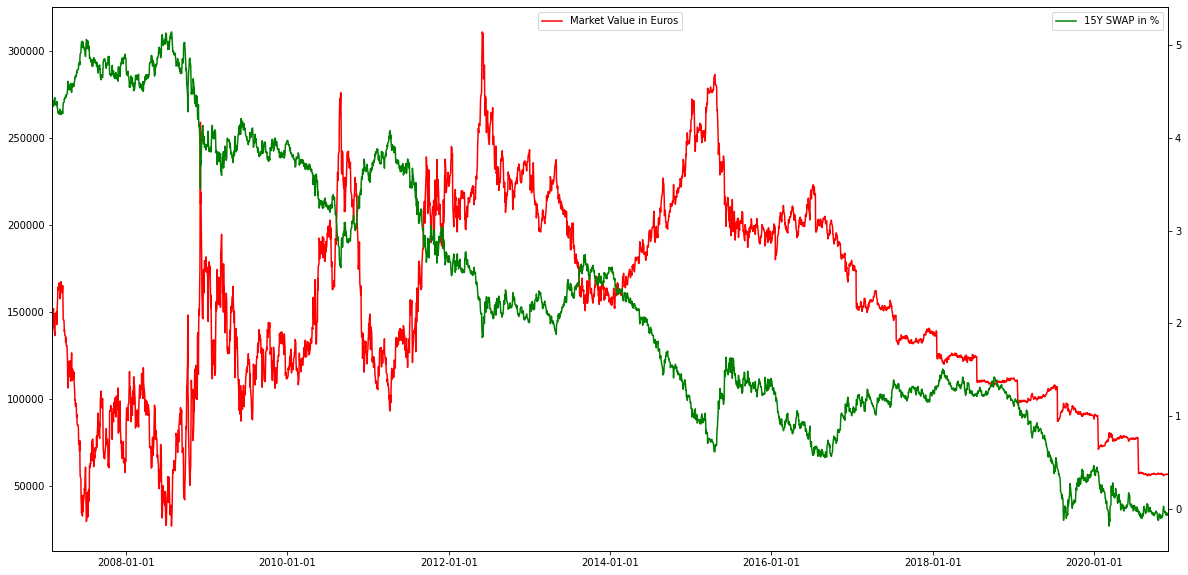

In [211]:
# plot for question 2f

y = market_value_df['Value']
x = market_value_df['Dates']
fig, ax = plt.subplots(figsize=(20, 10))
# market value
ax.plot(x, y, color='red', label="Market Value in Euros")
# set the x-axis limits to the range of dates in the data
ax.set_xlim(market_value_df['Dates'].min(), market_value_df['Dates'].max())
# format the x-axis as dates
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
#15Y SWAP
ax2 = ax.twinx()
ax2.plot(x, market_value_df['15Y_Swap'], color='green', label='15Y SWAP in %')
ax.legend(loc='upper center')
ax2.legend(loc='upper right')
plt.show()


In [213]:
#Question 2g)
b=date(2020,12,18)
swaps_hist_dez18=swaps.loc[str(b)].to_frame()
swaps_hist_dez18.columns=['par_rate']
swaps_hist_dez18.reset_index(inplace=True)
swaps_hist_dez18[['instrument', 'maturity']] = swaps_hist_dez18['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product
swaps_hist_dez18["maturity"] = swaps_hist_dez18["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities
swaps_hist_dez18['maturity_fra'] = swaps_hist_dez18['maturity'].str.split('X').str[1] #getting the maturity of the fra
swaps_hist_dez18.loc[swaps_hist_dez18["instrument"] == "FRA", "maturity"] = swaps_hist_dez18["maturity_fra"] #getting the new maturity
swaps_hist_dez18["year_frac"] = swaps_hist_dez18["maturity"].apply(extract_number)
swaps_hist_dez18.set_index('index',inplace=True)
forward_hist_dez18=swaps_hist_dez18.loc['FRA 6X12', 'par_rate']
one_year_rate_hist_dez18=(((1+swaps_hist_dez18.loc['Deposit 6M', 'par_rate'])**swaps_hist_dez18.loc['Deposit 6M', 'year_frac'])*(1+forward_hist_dez18)**(1-swaps_hist_dez18.loc['Deposit 6M', 'year_frac']))-1
yield_curve_hist_dez18 = swaps_hist_dez18[swaps_hist_dez18.index.str.contains("FRA") == False]
one_year_rate_hist_dez18 = pd.DataFrame([[one_year_rate_hist_dez18,'-','1Y','-',1.0]],
    index=['Swap 1Y'],
    columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])
yield_curve_hist_dez18=yield_curve_hist_dez18.append(one_year_rate_hist_dez18)
yield_curve_hist_dez18.set_index('year_frac',inplace=True)
yield_curve_hist_dez18.loc[0.5, 'df'] = 1 / (1 + (yield_curve_hist_dez18.loc[0.5, 'par_rate']/100) * 0.5)
yield_curve_hist_dez18.loc[0.5, 'zero_rate'] = yield_curve_hist_dez18.loc[0.5, 'par_rate']/100
yield_curve_hist_dez18.loc[1, 'df'] = 1 / (1 + yield_curve_hist_dez18.loc[1, 'par_rate']/100 * 1)
yield_curve_hist_dez18.loc[1, 'zero_rate'] = yield_curve_hist_dez18.loc[1, 'par_rate']/100
yield_curve_hist_dez18=yield_curve_hist_dez18.sort_index()
yield_curve_hist_dez18["Tenor"]= yield_curve_hist_dez18.index
yield_curve_hist_dez18['maturity'] = [b+relativedelta(months=+6)] + [date(b.year +int(n), b.month, b.day) for n in yield_curve_hist_dez18.index[1:]]
for n in range(0,len(yield_curve_hist_dez18['maturity'])):
    yield_curve_hist_dez18.iloc[n,2]=date(yield_curve_hist_dez18.iloc[n,2].year,yield_curve_hist_dez18.iloc[n,2].month,yield_curve_hist_dez18.iloc[n,2].day)
yield_curve_hist_dez18['days'] = yield_curve_hist_dez18.maturity.apply(lambda x: (x - date(b.year,b.month,b.day)).days)
idx_hist=0
row_hist=0
for idx_hist, row_hist in yield_curve_hist_dez18.loc[2:].iterrows():
    prev_dfs = yield_curve_hist_dez18.loc[1:idx_hist-1].df.sum()
    yield_curve_hist_dez18.loc[idx_hist, 'df'] = (1 - row_hist.par_rate/100 * prev_dfs) / (1+row_hist.par_rate/100)
for a in yield_curve_hist_dez18.index[2:]:
    yield_curve_hist_dez18.loc[a,'zero_rate']=((1/yield_curve_hist_dez18.loc[a,'df'])**(1/a))-1
b = date(b.year,b.month,b.day)

pd.options.display.float_format = '{:,.5f}'.format
float_leg_hist_dez18 = pd.DataFrame({'notional': swap_notional, 'start': loan_dates[:-1], 'end': loan_dates[1:]})
float_leg_hist_dez18['dcf'] = float_leg_hist_dez18.apply(lambda x: (x.end - x.start).days / 360, axis=1)
float_leg_hist_dez18['fwd'] = float_leg_hist_dez18.apply(lambda row: getFwd(row.start, row.end), axis=1)
float_leg_hist_dez18.loc[0, 'fwd'] = yield_curve_hist_dez18.loc[0.5, 'par_rate'] / 100
float_leg_hist_dez18['cf'] = float_leg_hist_dez18.notional * float_leg_hist_dez18.dcf * float_leg_hist_dez18.fwd
float_leg_hist_dez18['df'] = float_leg_hist_dez18.end.apply(getDF)
float_leg_hist_dez18['pv'] = float_leg_hist_dez18.cf * float_leg_hist_dez18.df
for n in range(0, len(float_leg_hist_dez18['notional'])):
    if  b>=float_leg_hist_dez18.iloc[n, 2]:
        float_leg_hist_dez18.iloc[n, 7]=0
float_leg_hist_pv_dez18 = float_leg_hist_dez18.pv.sum()


fixed_leg_hist_dez18 = pd.DataFrame({'notional': swap_notional, 'start': loan_dates[::1][:-1], 'end': loan_dates[::1][1:]})
fixed_leg_hist_dez18['dcf'] = 1
fixed_leg_hist_dez18['df'] = fixed_leg_hist_dez18.end.apply(getDF)
fixed_leg_hist_dez18['rate'] = fixed_rate
fixed_leg_hist_dez18['cashflow'] = fixed_leg_hist_dez18.notional * fixed_leg_hist_dez18.dcf * fixed_leg_hist_dez18.rate
fixed_leg_hist_dez18['pv'] = fixed_leg_hist_dez18.cashflow * fixed_leg_hist_dez18.df
for n in range(0, len(fixed_leg_hist_dez18['notional'])):
    if  b>=fixed_leg_hist_dez18.iloc[n, 2]:
        fixed_leg_hist_dez18.iloc[n, 7]=0
fixed_leg_hist_pv_dez18 = fixed_leg_hist_dez18.pv.sum()

mk_value_hist_dez18=fixed_leg_hist_pv_dez18-float_leg_hist_pv_dez18
print("Market values is ", mk_value_hist_dez18)

Market values is  -34423.371266911534


In [214]:
#2g)
float_leg_hist_dez18

,notional,start,end,dcf,fwd,cf,df,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,0.50278,-0.00520,"-4,571.75651",0.98097,0.00000
1,"1,748,653.15000",2007-07-19,2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,0.00000
2,"1,748,653.15000",2008-01-21,2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,0.00000
3,"1,748,653.15000",2008-07-21,2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,0.00000
4,"1,748,653.15000",2009-01-19,2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,0.00000
5,"1,748,653.15000",2009-07-20,2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,0.00000
6,"1,748,653.15000",2010-01-19,2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,0.00000
7,"1,748,653.15000",2010-07-19,2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,0.00000
8,"1,748,653.15000",2011-01-19,2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,0.00000
9,"1,748,653.15000",2011-07-19,2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,0.00000


In [215]:
#2g
fixed_leg_hist_dez18

,notional,start,end,dcf,df,rate,cashflow,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,1,0.98097,0.02331,"40,762.44852",0.00000
1,"1,748,653.15000",2007-07-19,2008-01-21,1,0.96118,0.02331,"40,762.44852",0.00000
2,"1,748,653.15000",2008-01-21,2008-07-21,1,0.94134,0.02331,"40,762.44852",0.00000
3,"1,748,653.15000",2008-07-21,2009-01-19,1,0.92150,0.02331,"40,762.44852",0.00000
4,"1,748,653.15000",2009-01-19,2009-07-20,1,0.90307,0.02331,"40,762.44852",0.00000
5,"1,748,653.15000",2009-07-20,2010-01-19,1,0.88453,0.02331,"40,762.44852",0.00000
6,"1,748,653.15000",2010-01-19,2010-07-19,1,0.86691,0.02331,"40,762.44852",0.00000
7,"1,748,653.15000",2010-07-19,2011-01-19,1,0.84900,0.02331,"40,762.44852",0.00000
8,"1,748,653.15000",2011-01-19,2011-07-19,1,0.83193,0.02331,"40,762.44852",0.00000
9,"1,748,653.15000",2011-07-19,2012-01-19,1,0.81458,0.02331,"40,762.44852",0.00000


In [216]:
#pv_cap = max(euribor - K;0)
#k =6 %
float_leg_c=float_leg
float_leg_c["cap_pv"] =1
float_leg_c["floor_pv"] =1
for n in range(0,len(float_leg_c["fwd"])):
    float_leg_c.iloc[n,8]=max(float_leg_c["fwd"][n]- 0.06, 0)
    

float_leg_c

,notional,start,end,dcf,fwd,cf,df,pv,cap_pv,floor_pv
0,"1,748,653.15000",2007-01-19,2007-07-19,0.50278,0.03880,"34,112.33706",0.98097,"33,463.15191",0.00000,1
1,"1,748,653.15000",2007-07-19,2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,"34,605.75683",0.00000,1
2,"1,748,653.15000",2008-01-21,2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,"34,690.93149",0.00000,1
3,"1,748,653.15000",2008-07-21,2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,"34,690.93149",0.00000,1
4,"1,748,653.15000",2009-01-19,2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,"32,237.80296",0.00000,1
5,"1,748,653.15000",2009-07-20,2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,"32,414.93374",0.00000,1
6,"1,748,653.15000",2010-01-19,2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,"30,811.97511",0.00000,1
7,"1,748,653.15000",2010-07-19,2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,"31,322.67083",0.00000,1
8,"1,748,653.15000",2011-01-19,2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,"29,839.82821",0.00000,1
9,"1,748,653.15000",2011-07-19,2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,"30,334.41100",0.00000,1


In [217]:
#ex 3  Alternative 1.
# swaption says that bank has the option, in 10 years to buy a swap with the exact same characteristics as 
#the swap contracted before, to pay X%
# >> X% 10Y 5Y

expiry_swaption = "2017-01-19"
tenor_swaption = "2022-01-19"

swaption_data_exercise = swaption_data.set_index("Expiry")
normalvol = swaption_data_exercise.loc["10Yr"].iloc[4]["NormalVol"]/10000
normalvol

0.023648

In [218]:
dates_swaption = []

for n in range(19, len(swaption_float_and_swap["end"])):
    dates_swaption.append(swaption_float_and_swap["end"][n])

dates_swaption

NameError: NameError: name 'swaption_float_and_swap' is not defined

In [219]:
dfs_swaption = []

for n in range(0, len(swaption_float_and_swap["df"])):
    for i in range(0, len(dates_swaption)):
        if swaption_float_and_swap["end"][n] != dates_swaption[i]:
            pass
        if swaption_float_and_swap["end"][n] == dates_swaption[i]:
            dfs_swaption.append(swaption_float_and_swap["df"][n])

dfs_swaption

NameError: NameError: name 'swaption_float_and_swap' is not defined

In [220]:
swaption_float_and_swap

NameError: NameError: name 'swaption_float_and_swap' is not defined

In [221]:
A = sum(dfs_swaption[1:])
L = 1748653.15
T = 10
#strike = X

    
swapRate = ([dfs_swaption[0] - dfs_swaption[-1]] / np.sum(dfs_swaption[1:]))[0]
A

IndexError: IndexError: list index out of range

In [222]:
from scipy.optimize import root

def swaptionPv(rate_swaption):

    fxd_swap = fixed_leg.copy()
    fixed_leg_pv_swap = (fxd_swap.notional * fxd_swap.dcf * fxd_swap.df * rate_swaption).sum()
    
    d = (swapRate - rate_swaption)/(normalvol * np.sqrt(10))
    swaption_pv = A * ((swapRate - rate_swaption)*norm.cdf(d) + normalvol * np.sqrt(10) * norm.pdf(d))
    

    return fixed_leg_pv_swap - float_leg_pv - swaption_pv


res2 = root(swaptionPv, 0)
fixed_rate2 = res2['x'][0]

print(f"Fixed rate And Swaption Strike:\t {fixed_rate2*100}%")

NameError: NameError: name 'swapRate' is not defined

In [223]:
#Exercise 3a: alternative 2
#pv_cap = max(euribor - K;0)
#k =6 %
float_leg_alt2=float_leg
float_leg_alt2["cap_pv"] =1
for n in range(0,len(float_leg_alt2["fwd"])):
    float_leg_alt2.iloc[n,8]=max(float_leg_alt2["fwd"][n]- 0.06, 0)

float_leg_alt2['tenor'] = [x * 0.5 for x in range(1, len(float_leg_alt2) + 1)]
capnormal_data['Int_Year'] = capnormal_data['Tenor'].apply(lambda x: float(x[:-2]))
capnormal_data_st6=capnormal_data[capnormal_data['Strike']=="6.00%"]
float_leg_alt2 = float_leg_alt2.merge(capnormal_data_st6, left_on='tenor',right_on="Int_Year",how="left")

def caplet_price(K,F,sigma,rf,start_date_cap,end_date_cap):
    P = np.exp(-rf*(end_date_cap-today_date).days/360)
    d1 = (np.log(F/K) + (sigma/100)**2 * ((start_date_cap-today_date).days/360) / 2) / ((sigma/100) * np.sqrt((start_date_cap-today_date).days/360))
    d2 = d1 - sigma/100
    caplet = (end_date_cap-start_date_cap).days/360 * P * ( F * norm.cdf(d1) - K * norm.cdf(d2))
    return caplet

float_leg_alt2 = float_leg_alt2.set_index('start')
float_leg_alt2['NormalVol'] = float_leg_alt2['NormalVol'].interpolate()
float_leg_alt2 = float_leg_alt2.reset_index()
float_leg_alt2['zero_rate'] = np.nan
for a in range(0,len(float_leg_alt2.iloc[:,9])):
    float_leg_alt2.loc[a,'zero_rate']=((1/float_leg_alt2.loc[a,'df'])**(1/float_leg_alt2.loc[a,'tenor']))-1

float_leg_alt2['caplet_price'] = np.nan
float_leg_alt2.loc[1:, 'caplet_price'] = float_leg_alt2.loc[1:, :].apply(lambda x: caplet_price(0.06, x['fwd'], x['NormalVol'], x['zero_rate'], x['start'], x['end']), axis=1)*swap_notional

price_cap_2a=float_leg_alt2['caplet_price'].sum()

float_leg_alt2.loc[0, 'pv']=float_leg_alt2.loc[0, 'pv']-price_cap_2a

float_leg_pv_alt2 = float_leg_alt2.pv.sum()
fixed_leg_alt2=fixed_leg
fixed_rate_alt2 = float_leg_pv_alt2 / (fixed_leg_alt2.notional *  fixed_leg_alt2.dcf * fixed_leg_alt2.df).sum()
print(f"Fair fixed rate is: {fixed_rate_alt2 * 100:.4f}%")

Fair fixed rate is: 1.9678%
